In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


Dataset Class from CSV

In [131]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        numFeat = 3 #------------------------
        numOut = 1
        numAhead = 0 # 0 means normal
        self.X = np.empty([numFeat,len(self.df)-numFeat-numOut],dtype=np.float32)
        self.Y = np.empty([numOut,len(self.df)-numFeat-numOut],dtype=np.float32)
        for i in range(self.Y.shape[1]):
            self.X[:,i] = np.asarray(self.df.iloc[i:i+numFeat]["TOTAL"])
            self.Y[:,i] = np.asarray(self.df.iloc[i+numFeat+numAhead:i+numFeat+numOut+numAhead]["TOTAL"])

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)

    def __len__(self):
        return self.Y.shape[1]
    
    def __getitem__(self,idx):
        return self.X[:,idx].T, self.Y[:,idx]

Initialize test and train dataloaders

In [132]:
#create data loaders
train_data = dataSetAll(1900,2010)
test_data = dataSetAll(2013,2100)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
print(list(train_data))

[(tensor([1291., 1513., 1552.]), tensor([1669.])), (tensor([1513., 1552., 1669.]), tensor([1897.])), (tensor([1552., 1669., 1897.]), tensor([2106.])), (tensor([1669., 1897., 2106.]), tensor([2204.])), (tensor([1897., 2106., 2204.]), tensor([2533.])), (tensor([2106., 2204., 2533.]), tensor([2242.])), (tensor([2204., 2533., 2242.]), tensor([2607.])), (tensor([2533., 2242., 2607.]), tensor([3086.])), (tensor([2242., 2607., 3086.]), tensor([3410.])), (tensor([2607., 3086., 3410.]), tensor([3349.])), (tensor([3086., 3410., 3349.]), tensor([5294.])), (tensor([3410., 3349., 5294.]), tensor([5501.])), (tensor([3349., 5294., 5501.]), tensor([6196.])), (tensor([5294., 5501., 6196.]), tensor([6730.])), (tensor([5501., 6196., 6730.]), tensor([6288.])), (tensor([6196., 6730., 6288.]), tensor([5867.])), (tensor([6730., 6288., 5867.]), tensor([4904.])), (tensor([6288., 5867., 4904.]), tensor([3975.])), (tensor([5867., 4904., 3975.]), tensor([3169.])), (tensor([4904., 3975., 3169.]), tensor([2658.])),

Create Neural Network Autoregression class

In [133]:
# create neural netowrk
class NeuralNetwork(nn.Module):
    def __init__(self):
        hidden = 400
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Create train and tet loops

In [134]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # print(pred)
        # print(y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # print(X)
            pred = model(X)
            # print(pred)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

Train the network

In [135]:
learning_rate = .000000001
batch_size = 64
epochs = 1000
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss: 11230162.000000  [    0/  633]
loss: 254332480.000000  [    0/  633]
loss: 7665992.000000  [    0/  633]
loss: 7626844.000000  [    0/  633]
loss: 7594569.000000  [    0/  633]
loss: 7566903.500000  [    0/  633]
loss: 7542916.500000  [    0/  633]
loss: 7521999.000000  [    0/  633]
loss: 7501506.000000  [    0/  633]
loss: 7481011.500000  [    0/  633]
loss: 7454636.500000  [    0/  633]
loss: 7327527.500000  [    0/  633]
loss: 6214563.500000  [    0/  633]
loss: 2600449.250000  [    0/  633]
loss: 801976.312500  [    0/  633]
loss: 837972.125000  [    0/  633]
loss: 821419.625000  [    0/  633]
loss: 815334.437500  [    0/  633]
loss: 808528.250000  [    0/  633]
loss: 802412.750000  [    0/  633]
loss: 796591.125000  [    0/  633]
loss: 790994.812500  [    0/  633]
loss: 785561.500000  [    0/  633]
loss: 780247.937500  [    0/  633]
loss: 775023.937500  [    0/  633]
loss: 769869.875000  [    0/  633]
loss: 764894.000000  [    0/  633]
loss: 760175.250000  [    0/  633]
los

Test on single input

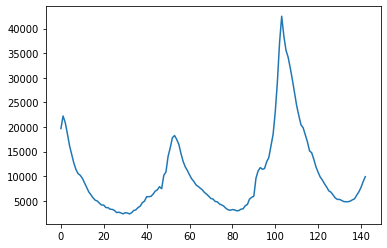

[19673 22224 20931 18668 16228 14491 12691 11354 10504 10165  9559  8647
  7722]
[[9559. 8647. 7722.]]
[[7198.906]]
[[6782.]]


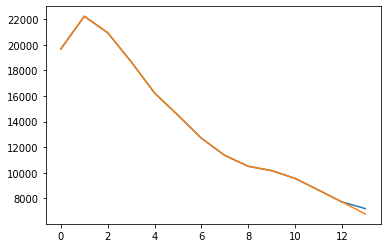

[22224 20931 18668 16228 14491 12691 11354 10504 10165  9559  8647  7722
  6782]
[[8647. 7722. 6782.]]
[[6246.377]]
[[6198.]]


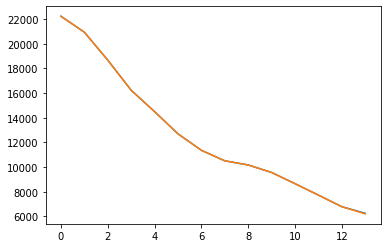

[20931 18668 16228 14491 12691 11354 10504 10165  9559  8647  7722  6782
  6198]
[[7722. 6782. 6198.]]
[[5807.322]]
[[5575.]]


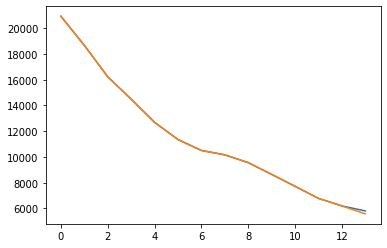

[18668 16228 14491 12691 11354 10504 10165  9559  8647  7722  6782  6198
  5575]
[[6782. 6198. 5575.]]
[[5229.525]]
[[5095.]]


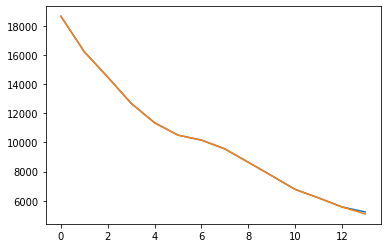

[16228 14491 12691 11354 10504 10165  9559  8647  7722  6782  6198  5575
  5095]
[[6198. 5575. 5095.]]
[[4800.7915]]
[[4919.]]


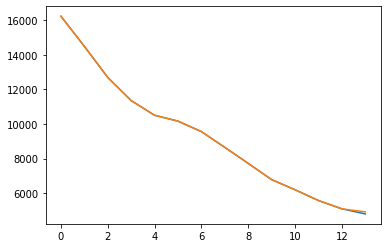

[14491 12691 11354 10504 10165  9559  8647  7722  6782  6198  5575  5095
  4919]
[[5575. 5095. 4919.]]
[[4777.989]]
[[4473.]]


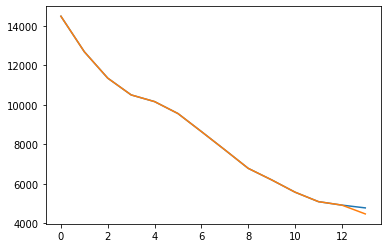

[12691 11354 10504 10165  9559  8647  7722  6782  6198  5575  5095  4919
  4473]
[[5095. 4919. 4473.]]
[[4271.1787]]
[[4102.]]


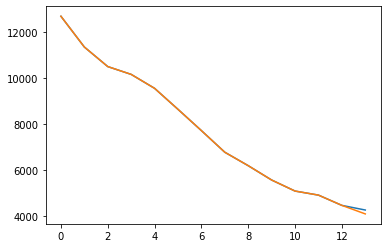

[11354 10504 10165  9559  8647  7722  6782  6198  5575  5095  4919  4473
  4102]
[[4919. 4473. 4102.]]
[[3881.5737]]
[[4097.]]


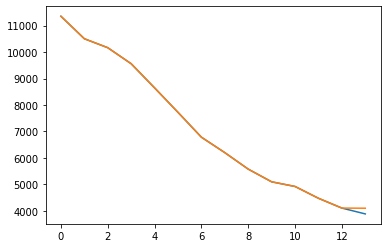

[10504 10165  9559  8647  7722  6782  6198  5575  5095  4919  4473  4102
  4097]
[[4473. 4102. 4097.]]
[[4044.3423]]
[[3587.]]


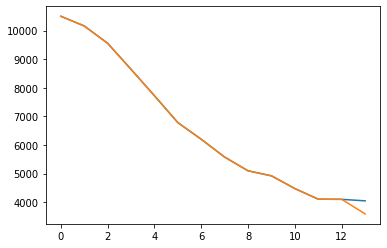

[10165  9559  8647  7722  6782  6198  5575  5095  4919  4473  4102  4097
  3587]
[[4102. 4097. 3587.]]
[[3385.401]]
[[3576.]]


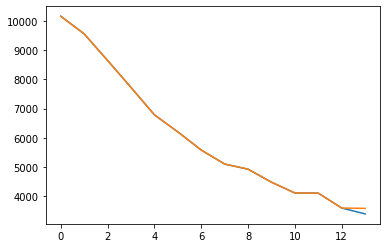

[9559 8647 7722 6782 6198 5575 5095 4919 4473 4102 4097 3587 3576]
[[4097. 3587. 3576.]]
[[3493.7764]]
[[3254.]]


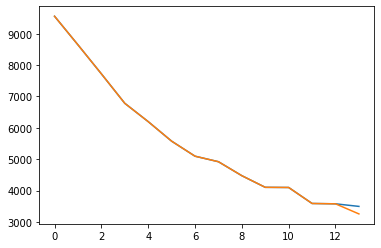

[8647 7722 6782 6198 5575 5095 4919 4473 4102 4097 3587 3576 3254]
[[3587. 3576. 3254.]]
[[3129.1904]]
[[3227.]]


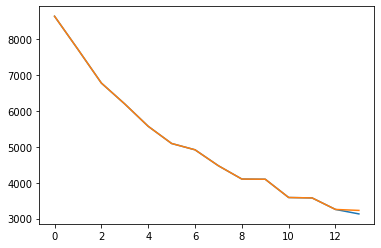

[7722 6782 6198 5575 5095 4919 4473 4102 4097 3587 3576 3254 3227]
[[3576. 3254. 3227.]]
[[3170.332]]
[[2999.]]


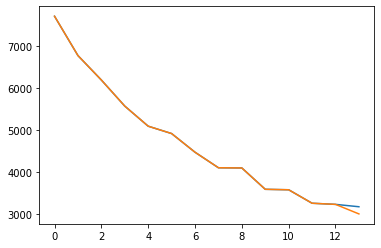

[6782 6198 5575 5095 4919 4473 4102 4097 3587 3576 3254 3227 2999]
[[3254. 3227. 2999.]]
[[2909.877]]
[[2579.]]


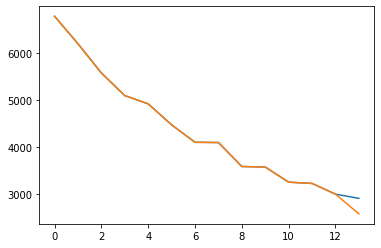

[6198 5575 5095 4919 4473 4102 4097 3587 3576 3254 3227 2999 2579]
[[3227. 2999. 2579.]]
[[2370.978]]
[[2653.]]


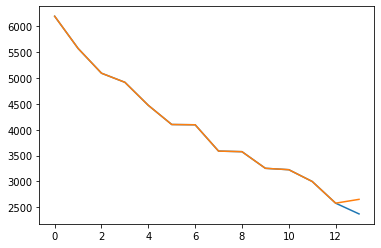

[5575 5095 4919 4473 4102 4097 3587 3576 3254 3227 2999 2579 2653]
[[2999. 2579. 2653.]]
[[2619.432]]
[[2504.]]


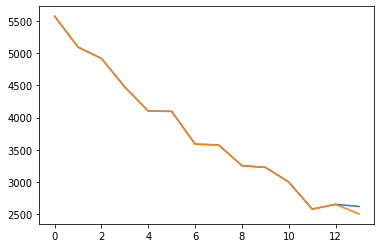

[5095 4919 4473 4102 4097 3587 3576 3254 3227 2999 2579 2653 2504]
[[2579. 2653. 2504.]]
[[2451.2114]]
[[2316.]]


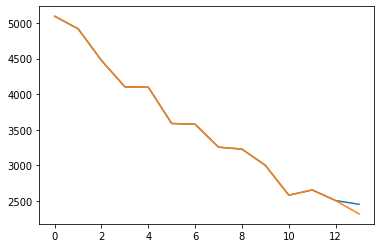

[4919 4473 4102 4097 3587 3576 3254 3227 2999 2579 2653 2504 2316]
[[2653. 2504. 2316.]]
[[2218.9285]]
[[2549.]]


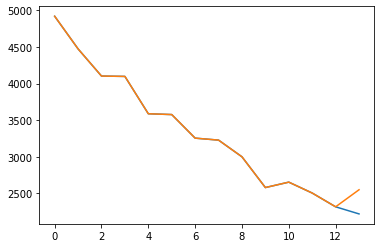

[4473 4102 4097 3587 3576 3254 3227 2999 2579 2653 2504 2316 2549]
[[2504. 2316. 2549.]]
[[2623.6025]]
[[2494.]]


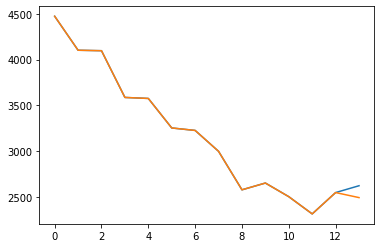

[4102 4097 3587 3576 3254 3227 2999 2579 2653 2504 2316 2549 2494]
[[2316. 2549. 2494.]]
[[2480.4692]]
[[2304.]]


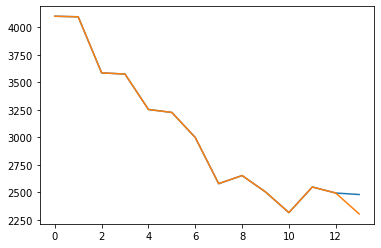

[4097 3587 3576 3254 3227 2999 2579 2653 2504 2316 2549 2494 2304]
[[2549. 2494. 2304.]]
[[2222.9885]]
[[2560.]]


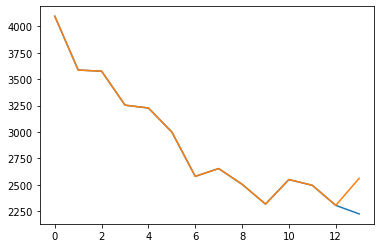

[3587 3576 3254 3227 2999 2579 2653 2504 2316 2549 2494 2304 2560]
[[2494. 2304. 2560.]]
[[2646.0103]]
[[3006.]]


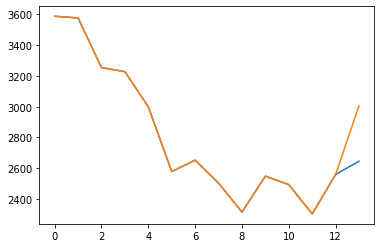

[3576 3254 3227 2999 2579 2653 2504 2316 2549 2494 2304 2560 3006]
[[2304. 2560. 3006.]]
[[3222.588]]
[[3148.]]


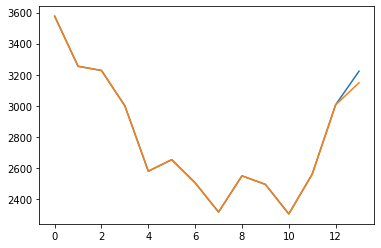

[3254 3227 2999 2579 2653 2504 2316 2549 2494 2304 2560 3006 3148]
[[2560. 3006. 3148.]]
[[3218.1746]]
[[3602.]]


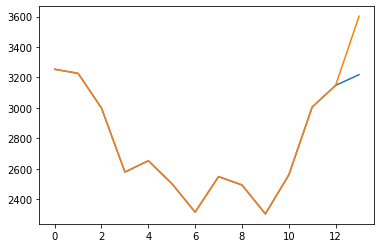

[3227 2999 2579 2653 2504 2316 2549 2494 2304 2560 3006 3148 3602]
[[3006. 3148. 3602.]]
[[3816.5813]]
[[3888.]]


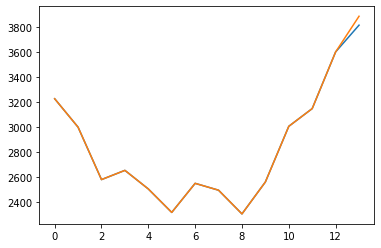

[2999 2579 2653 2504 2316 2549 2494 2304 2560 3006 3148 3602 3888]
[[3148. 3602. 3888.]]
[[4019.3303]]
[[4596.]]


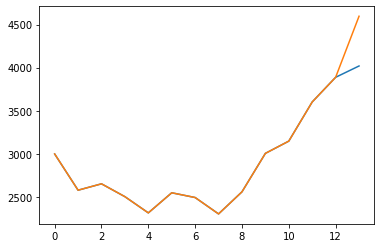

[2579 2653 2504 2316 2549 2494 2304 2560 3006 3148 3602 3888 4596]
[[3602. 3888. 4596.]]
[[4939.864]]
[[4911.]]


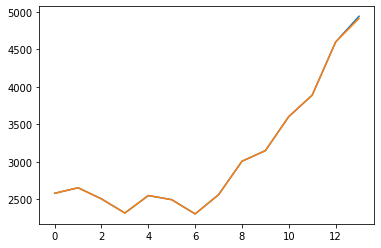

[2653 2504 2316 2549 2494 2304 2560 3006 3148 3602 3888 4596 4911]
[[3888. 4596. 4911.]]
[[5058.862]]
[[5808.]]


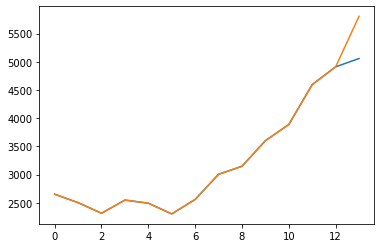

[2504 2316 2549 2494 2304 2560 3006 3148 3602 3888 4596 4911 5808]
[[4596. 4911. 5808.]]
[[6243.248]]
[[5801.]]


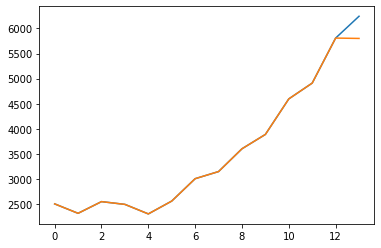

[2316 2549 2494 2304 2560 3006 3148 3602 3888 4596 4911 5808 5801]
[[4911. 5808. 5801.]]
[[5821.327]]
[[5886.]]


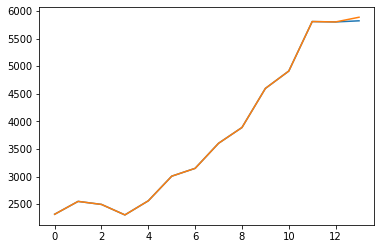

[2549 2494 2304 2560 3006 3148 3602 3888 4596 4911 5808 5801 5886]
[[5808. 5801. 5886.]]
[[5938.797]]
[[6316.]]


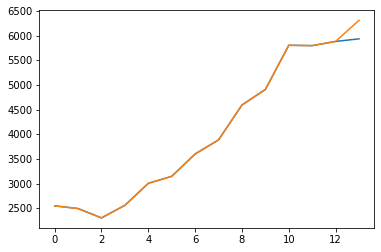

[2494 2304 2560 3006 3148 3602 3888 4596 4911 5808 5801 5886 6316]
[[5801. 5886. 6316.]]
[[6511.622]]
[[6945.]]


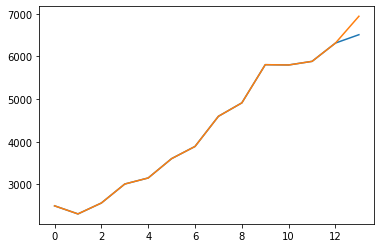

[2304 2560 3006 3148 3602 3888 4596 4911 5808 5801 5886 6316 6945]
[[5886. 6316. 6945.]]
[[7229.67]]
[[7203.]]


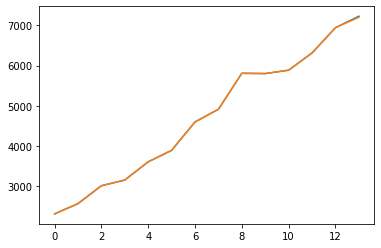

[2560 3006 3148 3602 3888 4596 4911 5808 5801 5886 6316 6945 7203]
[[6316. 6945. 7203.]]
[[7334.3604]]
[[7839.]]


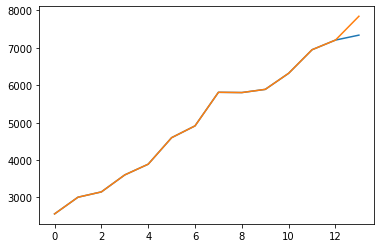

[3006 3148 3602 3888 4596 4911 5808 5801 5886 6316 6945 7203 7839]
[[6945. 7203. 7839.]]
[[8124.508]]
[[7433.]]


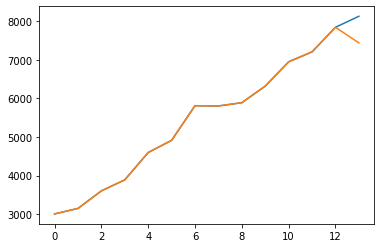

[3148 3602 3888 4596 4911 5808 5801 5886 6316 6945 7203 7839 7433]
[[7203. 7839. 7433.]]
[[7294.0947]]
[[10169.]]


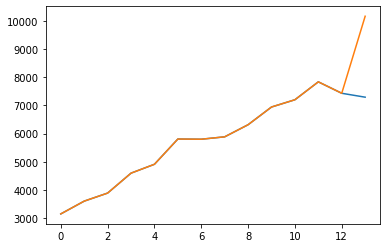

[ 3602  3888  4596  4911  5808  5801  5886  6316  6945  7203  7839  7433
 10169]
[[ 7839.  7433. 10169.]]
[[11510.574]]
[[10837.]]


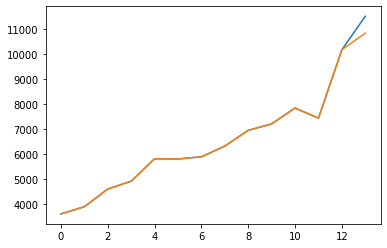

[ 3888  4596  4911  5808  5801  5886  6316  6945  7203  7839  7433 10169
 10837]
[[ 7433. 10169. 10837.]]
[[11159.364]]
[[14015.]]


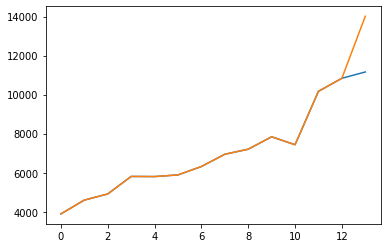

[ 4596  4911  5808  5801  5886  6316  6945  7203  7839  7433 10169 10837
 14015]
[[10169. 10837. 14015.]]
[[15606.74]]
[[15748.]]


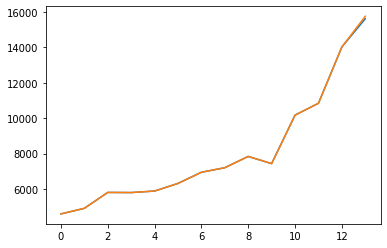

[ 4911  5808  5801  5886  6316  6945  7203  7839  7433 10169 10837 14015
 15748]
[[10837. 14015. 15748.]]
[[16585.84]]
[[17779.]]


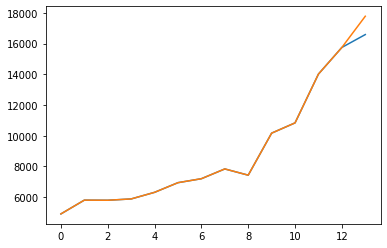

[ 5808  5801  5886  6316  6945  7203  7839  7433 10169 10837 14015 15748
 17779]
[[14015. 15748. 17779.]]
[[18740.736]]
[[18253.]]


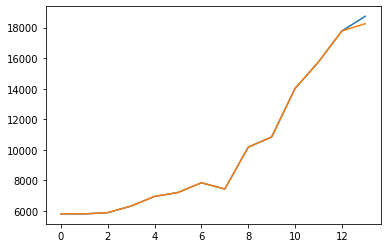

[ 5801  5886  6316  6945  7203  7839  7433 10169 10837 14015 15748 17779
 18253]
[[15748. 17779. 18253.]]
[[18515.463]]
[[17480.]]


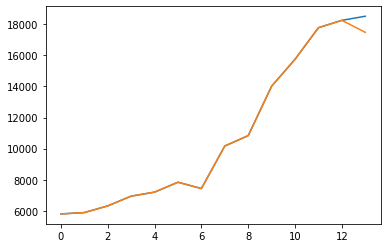

[ 5886  6316  6945  7203  7839  7433 10169 10837 14015 15748 17779 18253
 17480]
[[17779. 18253. 17480.]]
[[17222.014]]
[[16468.]]


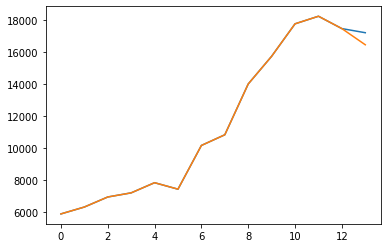

[ 6316  6945  7203  7839  7433 10169 10837 14015 15748 17779 18253 17480
 16468]
[[18253. 17480. 16468.]]
[[15969.237]]
[[14618.]]


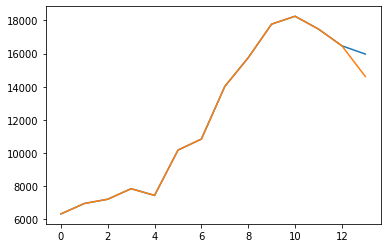

[ 6945  7203  7839  7433 10169 10837 14015 15748 17779 18253 17480 16468
 14618]
[[17480. 16468. 14618.]]
[[13715.331]]
[[12995.]]


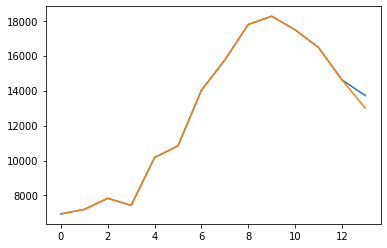

[ 7203  7839  7433 10169 10837 14015 15748 17779 18253 17480 16468 14618
 12995]
[[16468. 14618. 12995.]]
[[12030.215]]
[[11892.]]


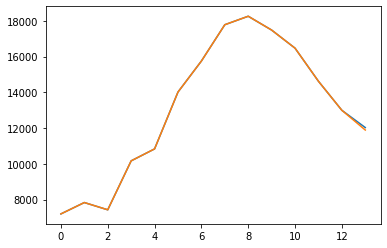

[ 7839  7433 10169 10837 14015 15748 17779 18253 17480 16468 14618 12995
 11892]
[[14618. 12995. 11892.]]
[[11182.793]]
[[11127.]]


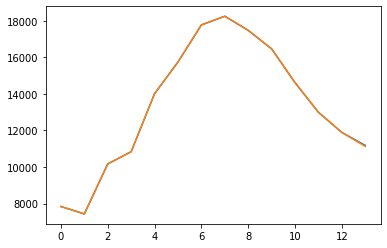

[ 7433 10169 10837 14015 15748 17779 18253 17480 16468 14618 12995 11892
 11127]
[[12995. 11892. 11127.]]
[[10650.889]]
[[10252.]]


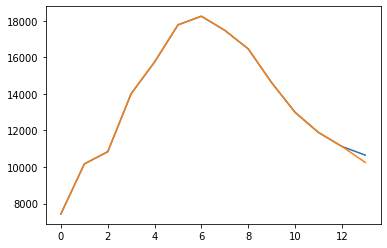

[10169 10837 14015 15748 17779 18253 17480 16468 14618 12995 11892 11127
 10252]
[[11892. 11127. 10252.]]
[[9786.884]]
[[9441.]]


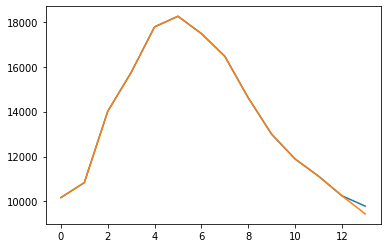

[10837 14015 15748 17779 18253 17480 16468 14618 12995 11892 11127 10252
  9441]
[[11127. 10252.  9441.]]
[[8979.69]]
[[8922.]]


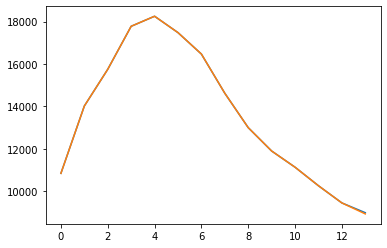

In [138]:
with torch.no_grad():
    model.eval()
    numOut = 1
    numSkip = 1
    numFeat = 3
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    plt.plot(data)
    plt.show()
    for i in range(10,60):
        feat = test_data[i:i+1][0].numpy()
        pred = model(test_data[i:i+1][0]).numpy()
        act = test_data[i:i+1][1].numpy()
        full_back = data[i-10:i+numFeat]
        print(full_back)
        print(feat)
        print(pred)
        print(act)
        # plt.plot(full_back)
        plt.plot(np.append(full_back,pred))
        plt.plot(np.append(full_back,act))
        plt.show()
